# Training and evaluating various ML models for drug sensitivity prediction

In the `data_exploration.ipynb` I went over the exploratory data analysis (EDA) of the provided dataset. Now, using the conclusions gained with EDA, I will train multiple models for predicting drug sensitivity.

## Preprocessing of the dataset

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting up pandas printing options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None) 

# Setting up working environment
base_path = Path.cwd()
os.chdir(base_path)

# Print out the current working directory
print(base_path)

/Users/ferenc.kagan/Documents/Projects/Archive/Turbine_hw


In [2]:
# Setting up multi-threading
OMP_NUM_THREADS=1
MKL_NUM_THREADS=1
OPENBLAS_NUM_THREADS=1
BLIS_NUM_THREADS=1

In [3]:
# Read in the provided data

# Gene expression dataset
expr = pd.read_csv("input/CCLE_expression.csv")

# Metadata of the samples
metadata = pd.read_csv("input/sample_info.csv")

#Drug sensitivity data
sens = pd.read_excel("input/GDSC2_fitted_dose_response_25Feb20.xlsx")

In [4]:
# Prepare data for downstream analysis
metadata = metadata[metadata['DepMap_ID'].isin(expr['Unnamed: 0'])]
metadata = metadata.set_index('DepMap_ID').reindex(expr['Unnamed: 0']).reset_index()

# Bring together all tables into singular giant table
merged_df = expr.merge(metadata, left_on='Unnamed: 0', right_on='Unnamed: 0').merge(sens[sens['DRUG_NAME'] == 'Lapatinib'], left_on='Sanger_Model_ID', right_on='SANGER_MODEL_ID')

# Replace unknown sex with NaN to be imputed
merged_df.loc[merged_df["sex"] == "Unknown", "sex"] = np.nan

## Strategy #1

I will attempt to train regression ML models to predict drug sensitivity. For this I will use the preprocessed gene expression data only. 

### Preprocessing of the data

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import uniform, randint
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import KBinsDiscretizer

# Subset the data to only include the necessary columns and bring the data into the normal scale
subset_df = merged_df.iloc[:, 1:(expr.shape)[1]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(subset_df, merged_df['LN_IC50'], test_size=0.2, random_state=17)

### Multi-phase training

Since I will have to compare many models, I will want to save some time by employing a two phase approach for model selection. Phase 1 will compare all models using baseline hyperparameters implemented in each algorithm. The top ranking models from phase 1 will then be selected for phase two, where a hyperparameter optimization will happen.

In [ ]:
# Define the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler())
        ]), X_train.columns)
    ]
)

# Define list of models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

# Define models and parameter grids
model_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': uniform(0.1, 10)}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': uniform(0.1, 10)}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {'alpha': uniform(0.1, 10), 'l1_ratio': uniform(0, 1)}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': randint(2, 20), 'min_samples_split': randint(2, 20)}
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(n_jobs=15),
        'params': {'n_estimators': randint(50, 200), 'max_depth': randint(2, 20)}
    },
    'ExtraTreesRegressor': {
        'model': ExtraTreesRegressor(n_jobs=15),
        'params': {'n_estimators': randint(50, 200), 'max_depth': randint(2, 20)}
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.3)}
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(),
        'params': {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 1.0)}
    },
    'BaggingRegressor': {
        'model': BaggingRegressor(n_jobs=15),
        'params': {'n_estimators': randint(10, 100)}
    },
    'HistGradientBoostingRegressor': {
        'model': HistGradientBoostingRegressor(),
        'params': {'learning_rate': uniform(0.01, 0.3), 'max_depth': randint(2, 20)}
    },
    'SVR': {
        'model': SVR(),
        'params': {'C': uniform(0.1, 10), 'gamma': uniform(0.01, 1)}
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(n_jobs=15),
        'params': {'n_neighbors': randint(2, 20), 'weights': ['uniform', 'distance']}
    },
    'CatBoostRegressor': {
        'model': CatBoostRegressor(thread_count=15, verbose=0),
        'params': {'learning_rate': uniform(0.01, 0.3), 'depth': randint(2, 10)}
    }
}



In [ ]:
from utils import tune_models

# Initialize outputs
best_models = {}
mse_results = {}

# Train models
best_models, mse_results = tune_models(
    model_params=model_params,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    n_iter=50,  
    cv=5,       
    n_jobs=15,   
    random_state=17 
)

In [ ]:
from utils import evaluate_tuned_models

save_path = "output/evaluation_results_gene_exp.csv"
strategy_name = "Strategy 1: Gene Expression Only"  

# Evaluate trained models
evaluate_tuned_models(
    best_models=best_models, 
    mse_results=mse_results,  
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    strategy=strategy_name,
    save_path=save_path,
)

In [ ]:
# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE']).sort_values(by='MSE')

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='MSE', y='Model', palette='viridis')

plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Regression Models")
plt.title("Comparison of Model Performance (MSE) after Hyperparameter Tuning")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("output/mse_gene-exp.pdf")
plt.show()

In [ ]:
from utils import plot_all_learning_curves

# Plot learning curves for all models in Phase 1
plot_all_learning_curves(best_models, X_train, y_train, output_filename="output/faceted_learning_curves_gene-exp.pdf")


In [ ]:
from utils import evaluate_models

# Evaluate models
evaluate_models(best_models, X_train, y_train, X_test, y_test, save_plot_path="output/test_set_mse_gene-exp.pdf")

## Strategy #2

Will try an approach with a feature selection algorithm (genetic algorithm) and I will furthermore add extended metadata to the gene expression table.

In [ ]:
from deap import base, creator, tools, algorithms

# Extract relevant columns
categorical_cols = ['primary_disease', 'sex']
numerical_cols = ['age']

# One-hot encode categorical features
subset_df = merged_df.iloc[:, 1:(expr.shape)[1]]
subset_df = pd.concat([subset_df, merged_df[categorical_cols + numerical_cols]], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(subset_df, merged_df['LN_IC50'], test_size=0.2, random_state=17)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler())
        ]), X_train.columns[:-3]),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),  
        
        ('age', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age'])
    ]
)

In [ ]:
# Genetic Algorithm for Feature Selection
print("Setting up genetic algorithm for feature selection...")

# Prepare data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert to DataFrame
feature_names = (preprocessor.named_transformers_['num'][1].get_feature_names_out().tolist() +
                 preprocessor.named_transformers_['cat'][1].get_feature_names_out().tolist() +
                 ['age'])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Number of features after preprocessing
num_features = X_train_transformed.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize neg_MSE
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define fitness function
# Evaluation function using cross-validation
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    
    if len(selected_features) < 10:  # Prevent too few features
        return -np.inf,
    
    X_selected = X_train_transformed.iloc[:, selected_features]
    
    model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    
    score = np.mean(cross_val_score(model, X_selected, y_train, cv=5, scoring="neg_mean_squared_error"))
    return score,

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [ ]:
# Run Genetic Algorithm
pop_size = 100  # Adjust population size
num_generations = 200  # Adjust generations

pop = toolbox.population(n=pop_size)
hall_of_fame = tools.HallOfFame(1)  # Keep the best individual
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                               stats=stats, halloffame=hall_of_fame, verbose=True)

# After the genetic algorithm
best_individual = hall_of_fame[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]
print(f"Selected {len(selected_features)} features from {num_features} total.")

# Reduce feature set
X_train = X_train.iloc[:, selected_features]
X_test = X_test.iloc[:, selected_features]

In [ ]:
# The GA dropped categorical columns, will have to adapt the preprocessing pipeline accordingly
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler())
        ]), X_train.columns)
    ]
)

# Initialize outputs
best_models = {}
mse_results = {}

# Train models
best_models, mse_results = tune_models(
    model_params=model_params,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    n_iter=50,  
    cv=5,       
    n_jobs=15,   
    random_state=17 
)

In [ ]:
save_path = "output/evaluation_results_ga-metadata.csv"
strategy_name = "Strategy 2: Enchanced data with Feature Selection"  

# Evaluate trained models
evaluate_tuned_models(
    best_models=best_models, 
    mse_results=mse_results,  
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    strategy=strategy_name,
    save_path=save_path,
)

In [ ]:
# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE']).sort_values(by='MSE')

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='MSE', y='Model', palette='viridis')

plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Regression Models")
plt.title("Comparison of Model Performance (MSE) after Hyperparameter Tuning")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("output/mse_ga-metadata.pdf")
plt.show()

In [ ]:
# Plot learning curves for all models in Phase 1
plot_all_learning_curves(best_models, X_train, y_train, output_filename="output/faceted_learning_curves_ga-metadata.pdf")


In [ ]:
# Evaluate models
evaluate_models(best_models, X_train, y_train, X_test, y_test, save_plot_path="output/test_set_mse_ga-metadata.pdf")

## Strategy #3

Will try a dimensionality reduction approach, enchanced with metadata.

In [ ]:
# Extract relevant columns
print("Starting strategy #3...", flush=True)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler()),
            ('dr', PCA(n_components=0.95))
        ]), X_train.columns[:-3]),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),  
        
        ('age', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age'])
    ]
)

Starting strategy #2...


In [ ]:
# Initialize outputs
best_models = {}
mse_results = {}

# Train models
best_models, mse_results = tune_models(
    model_params=model_params,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    n_iter=50,  
    cv=5,       
    n_jobs=15,   
    random_state=17 
)

In [ ]:
save_path = "output/evaluation_results_dr-metadata.csv"
strategy_name = "Strategy 3: Enchanced data with Dimensionality reduction"  

# Evaluate trained models
evaluate_tuned_models(
    best_models=best_models, 
    mse_results=mse_results,  
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    strategy=strategy_name,
    save_path=save_path,
)

In [ ]:
# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE']).sort_values(by='MSE')

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='MSE', y='Model', palette='viridis')

plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Regression Models")
plt.title("Comparison of Model Performance (MSE) after Hyperparameter Tuning")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("output/mse_dr-metadata.pdf")
plt.show()

In [ ]:
# Plot learning curves for all models in Phase 1
plot_all_learning_curves(best_models, X_train, y_train, output_filename="output/faceted_learning_curves_dr-metadata.pdf")


In [ ]:
# Evaluate models
evaluate_models(best_models, X_train, y_train, X_test, y_test, save_plot_path="output/test_set_mse_dr-metadata.pdf")

## Strategy #4

Will try quantile binning of gene expression datasets and will enchance with additional metadata.

In [ ]:
print("Starting strategy #4...", flush=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(subset_df, merged_df['LN_IC50'], test_size=0.2, random_state=17)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler()),
            ('quantile_binning', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
        ]), X_train.columns[:-3]),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),  
        
        ('age', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age'])
    ]
)

In [ ]:
best_models = {}
mse_results = {}

best_models, mse_results = tune_models(
    model_params=model_params,
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    n_iter=50,  
    cv=5,       
    n_jobs=15,   
    random_state=17 
)

In [ ]:
save_path = "output/evaluation_results_bin-metadata.csv"
strategy_name = "Strategy 4: Enchanced data with Quantile Binning"  

# Evaluate trained models
evaluate_tuned_models(
    best_models=best_models, 
    mse_results=mse_results,  
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    strategy=strategy_name,
    save_path=save_path,
)

In [ ]:
# Convert to DataFrame for plotting
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE']).sort_values(by='MSE')

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='MSE', y='Model', palette='viridis')

plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Regression Models")
plt.title("Comparison of Model Performance (MSE) after Hyperparameter Tuning")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("output/mse_bin-metadata.pdf")
plt.show()

In [ ]:
# Plot learning curves for all models in Phase 1
plot_all_learning_curves(best_models, X_train, y_train, output_filename="output/faceted_learning_curves_bin-metadata.pdf")

In [ ]:
# Evaluate models
evaluate_models(best_models, X_train, y_train, X_test, y_test, save_plot_path="output/test_set_mse_bin-metadata.pdf")

## Strategy #5

Will try DR with a combination of NN.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

print("Initialize DL...", flush=True)

def create_model(input_dim, l2_reg=0.01):
    model = tf.keras.Sequential([
        # Input Layer
        layers.InputLayer(input_shape=(input_dim,)),
        layers.BatchNormalization(),
        
        # Hidden Layer 1
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden Layer 2
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden Layer 3
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output Layer
        layers.Dense(1)  # Linear activation for regression
    ])
    
    return model

Initialize DL...


In [ ]:
print("Preprocess data for DL...")

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler())
        ]), X_train.columns[:-3]),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),  
        
        ('age', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age'])
    ]
)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert to numpy arrays if they're not already
X_train_preprocessed = X_train_preprocessed.toarray() if scipy.sparse.issparse(X_train_preprocessed) else X_train_preprocessed
X_test_preprocessed = X_test_preprocessed.toarray() if scipy.sparse.issparse(X_test_preprocessed) else X_test_preprocessed

Preprocess data for DL...


In [17]:
print("Compile DL...", flush=True)

# Create the model
input_dim = X_train_preprocessed.shape[1]
model = create_model(input_dim)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

# Print model summary
model.summary()

Compile DL...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 376)            │         1,504 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       193,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362,465 (1.38 MB)

 Trainable params: 359,921 (1.37 MB)

 Non-trainable params: 2,544 (9.94 KB)

In [ ]:
print("Fitting DL...", flush=True)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_preprocessed, y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Fitting DL...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 23.9836 - mse: 14.5284 - val_loss: 23.6696 - val_mse: 14.2183
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20.9527 - mse: 11.5018 - val_loss: 19.8238 - val_mse: 10.3774
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.6454 - mse: 9.2018 - val_loss: 18.4135 - val_mse: 8.9810
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.4278 - mse: 9.0002 - val_loss: 16.9591 - val_mse: 7.5490
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 16.9880 - mse: 7.5845 - val_loss: 16.5047 - val_mse: 7.1235
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 16.0847 - mse: 6.7111 - val_loss: 16.5863 - val_mse: 7.2375
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 15.5445 - mse: 6.2035 - val_loss: 16.2554 - val_mse: 6.9389
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 15.1687 - mse: 5.8605 - val_loss: 15.6079 - val_mse: 6.3263
Epoch 9/100
12/12 ━━━━

In [22]:
print("Evaluate DL...", flush=True)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print(f"Test neg_mean_squared_error: {test_mae:.4f}", flush=True)

# Make predictions
y_pred = model.predict(X_test_preprocessed)

# Calculate R-squared
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2:.4f}", flush=True)
print(f"MSE: {mse:.4f}", flush=True)

Evaluate DL...
Test neg_mean_squared_error: 2.3330
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R-squared: 0.1554
MSE: 2.3330


Visualize DL...


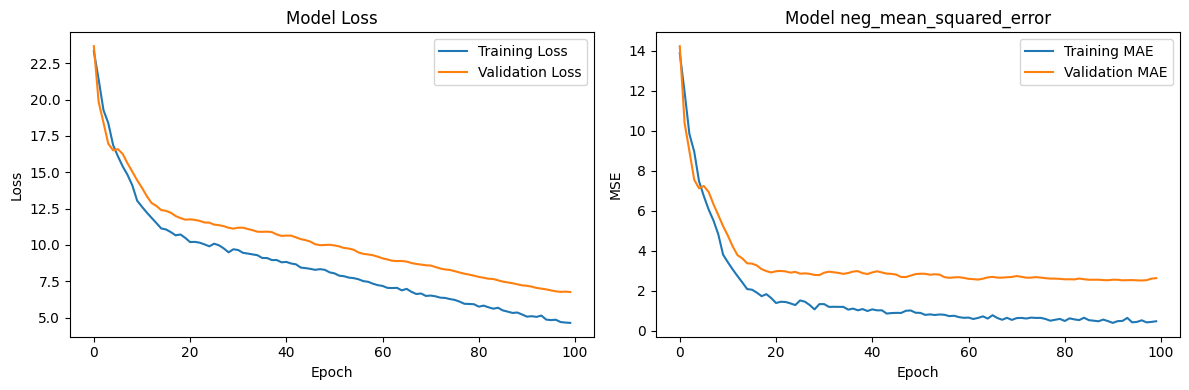

In [23]:
print("Visualize DL...", flush=True)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MAE')
plt.plot(history.history['val_mse'], label='Validation MAE')
plt.title('Model neg_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.savefig("output/neural_network_learning.pdf")
plt.show()
